In [79]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.autograd import Variable

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
x_data = housing.data
y_data = housing.target

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

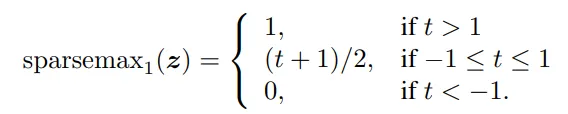


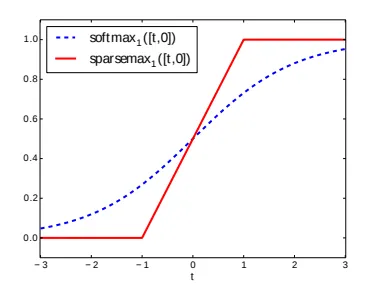

In [27]:
class Sparsemax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = -1 if dim is None else dim

    def forward(self, input):
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)
        
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, device=device,step=1, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]
        zs_sparse = is_gt * zs
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)
        self.output = torch.max(torch.zeros_like(input), input - taus)
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)
        return output

    def backward(self, grad_output):
        dim = 1
        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))
        return self.grad_input

In [100]:
class GBN(nn.Module):
    def __init__(self,inp,vbs=128,momentum=0.01):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs

    def forward(self,x):
        chunk = torch.chunk(x,max(1,x.size(0)//self.vbs),0)
        res = [self.bn(y) for y in chunk ]
        return torch.cat(res,0)

class GLU(nn.Module):
    def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
        super().__init__()
        if fc:
            self.fc = fc
        else:
            self.fc = nn.Linear(inp_dim,out_dim*2)
        self.bn = GBN(out_dim*2,vbs=vbs) 
        self.od = out_dim

    def forward(self,x):
        x = self.bn(self.fc(x))
        return x[:,:self.od]*torch.sigmoid(x[:,self.od:])

class FeatureTransformer(nn.Module):
    def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
        super().__init__()
        first = True
        self.shared = nn.ModuleList()
        if shared:
            self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
            first= False    
            for fc in shared[1:]:
                self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
        else:
            self.shared = None
        self.independ = nn.ModuleList()
        if first:
            self.independ.append(GLU(inp_dim,out_dim,vbs=vbs))
        for x in range(first, n_ind):
            self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
        self.scale = torch.sqrt(torch.tensor([.5],device=device))

    def forward(self,x):
        if self.shared:
            x = self.shared[0](x)
            for glu in self.shared[1:]:
                x = torch.add(x, glu(x))
                x = x*self.scale
        for glu in self.independ:
            x = torch.add(x, glu(x))
            x = x*self.scale
        return x

class AttentionTransformer(nn.Module):
    def __init__(self,inp_dim,out_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(inp_dim,out_dim)
        self.bn = GBN(out_dim,vbs=vbs)
        self.smax = Sparsemax()
        self.r = torch.tensor([relax],device=device)
        
    def forward(self,a,priors):
        a = self.bn(self.fc(a))
        mask = torch.sigmoid(a*priors)
        priors =priors*(self.r-mask)
        return mask

class DecisionStep(nn.Module):
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran = AttentionTransformer(n_a,inp_dim,relax,vbs)
    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,loss

class TabNet(nn.Module):
    def __init__(self,inp_dim,final_out_dim,n_d=64,n_a=64,n_shared=2,n_ind=2,n_steps=5,relax=1.2,vbs=128):
        super().__init__()
        if n_shared>0:
            self.shared = nn.ModuleList()
            self.shared.append(nn.Linear(inp_dim,2*(n_d+n_a)))
            for x in range(n_shared-1):
                self.shared.append(nn.Linear(n_d+n_a,2*(n_d+n_a)))
        else:
            self.shared=None
        self.first_step = FeatureTransformer(inp_dim,n_d+n_a,self.shared,n_ind) 
        self.steps = nn.ModuleList()
        for x in range(n_steps-1):
            self.steps.append(DecisionStep(inp_dim,n_d,n_a,self.shared,n_ind,relax,vbs))
        self.fc = nn.Linear(n_d,final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim)
        self.n_d = n_d
    def forward(self,x):
        x = self.bn(x)
        x_a = self.first_step(x)[:,self.n_d:]
        loss = torch.zeros(1).to(x.device)
        out = torch.zeros(x.size(0),self.n_d).to(x.device)
        priors = torch.ones(x.shape).to(x.device)
        for step in self.steps:
            x_te,l = step(x,x_a,priors)
            out += F.relu(x_te[:,:self.n_d])
            x_a = x_te[:,self.n_d:]
            loss += l
        return self.fc(out),loss

In [82]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [86]:
y_train.shape

torch.Size([14448])

In [87]:
loss_func = loss_fn = lambda y_true, y_pred: ((y_true - y_pred)**2).mean()
model = TabNet(X_train.shape[1],1,n_d=128,n_a=16,n_shared=1,n_ind=4,n_steps=3,relax=1.5,vbs=64)
optimizer = optim.Adam(model.parameters(),lr=0.007809719000164987,weight_decay=0.00001)

In [101]:
from sklearn import metrics
import tqdm

EPOCHS  = 10


loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))


for epoch in tqdm.trange(EPOCHS):
    out, l = model(X_train)
    loss = loss_func(out, y_train.reshape(y_train.shape[0], 1))
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred, l = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


In [94]:
y_pred

tensor([[0.9192],
        [1.9197],
        [2.0579],
        ...,
        [1.4672],
        [4.0988],
        [1.7059]])

In [98]:
y_test

tensor([0.8750, 1.7370, 2.8090,  ..., 0.8720, 5.0000, 3.2000])

In [99]:
loss_list

array([0.64923567, 0.5626111 , 0.55007923, 0.55512989, 0.53340739,
       0.49653763, 0.47206238, 0.46908927, 0.47407097, 0.4667547 ])